## **Preprocessing**

### ***Library***

In [ ]:
import warnings # to avoid the warnings
warnings.filterwarnings('ignore')
!pip install category_encoders
!pip install geopandas
!pip install geoplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 115.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 9.6 MB/s eta 0:00:00
     ━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns
import re
from sklearn import tree
import math
import time
from datetime import datetime

In [ ]:
#Geo
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

### **1. Data Cleaning**

In [ ]:
file=pd.read_csv('Dataset_house_price.csv')

#### ***Price***

In [ ]:
price = file['Price']
price

0            9.2 tỷ
1            2.9 tỷ
2             14 tỷ
3        Thỏa thuận
4            3.7 tỷ
           ...     
9591    54444.44 tỷ
9592        10.8 tỷ
9593         5.5 tỷ
9594         5.5 tỷ
9595        4.85 tỷ
Name: Price, Length: 9596, dtype: object

> **Vấn đề:**
*   Đơn vị tiền tệ không đồng nhất: tỷ, triệu, nghìn.
*   Giá trị không hợp lí: giá quá cao hoặc quá thấp.

> **Giải quyết:**
*   Đồng nhất đơn vị tiền tệ là *tỷ* đồng
*   Thay thế các giá trị "*Thỏa thuận*"

In [ ]:
#Xử lý giá
price=file['Price'].astype(str)
for i in range(len(price)):
    if re.findall('Thỏa thuận',price[i]):
        price[i]=np.nan
    elif re.findall(r'(\d+.?\d?\d?) (tỷ)',price[i]):
        temp1=float(re.findall(r'(\d+.?\d?\d?) (tỷ)',price[i])[0][0])
        if temp1 >1000000000:#>10^9 tỷ
            price[i]=temp1/1000000000
        elif temp1>100000000:#>10^8 tỷ
            price[i]=temp1/100000000
        elif temp1>10000000:#>10^7 tỷ
            price[i]=temp1/10000000
        elif temp1 >1000000:#>10^6 tỷ
            price[i]=temp1/1000000
        elif temp1 > 100000:#>10^5 tỷ
            price[i]=temp1/100000
        elif temp1 >500:#>5*10^2 tỷ
            price[i]=temp1/1000
        else:
            price[i]=temp1
    elif re.findall(r'(\d+.?\d?\d?) (triệu)',price[i]):
        temp2=float(re.findall(r'(\d+.?\d?\d?) (triệu)',price[i])[0][0])
        if temp2>1000000: #>10^6 triệu
            price[i]=temp2/1000000
        elif temp2>1000:#>10^3 triệu
            price[i]=temp2/1000
        elif temp2>100:# >10^2 triệu
            price[i]=temp2/1000
        else:#<10^2 triệu
            price[i]=temp2
    else:
        price[i]=float(price[i].split()[0])/1000# 900 nghìn

price=pd.to_numeric(price)
file['Price']=price

In [ ]:
file.Price.describe()

count    8760.000000
mean        9.038449
std        22.246475
min         0.047000
25%         3.590000
50%         5.300000
75%         8.000000
max       500.000000
Name: Price, dtype: float64

In [ ]:
t=file[file['Price'] <50]
s=file[file['Price'] >50]

Text(0.5, 1.0, 'Price bé hơn 50 tỷ')

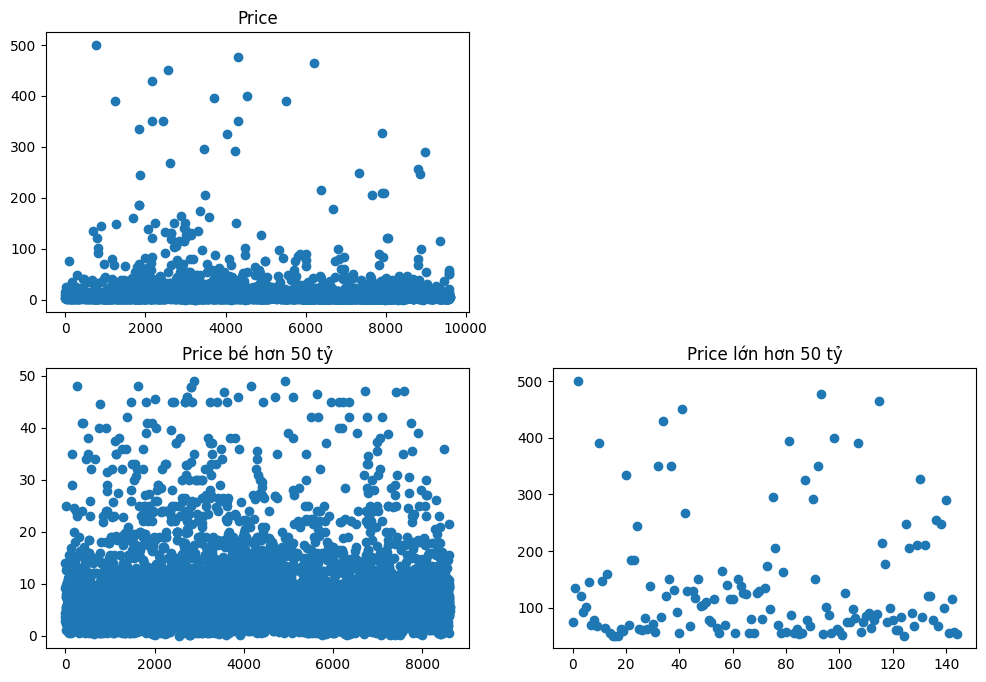

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)
ax1.scatter(range(0,len(file['Price'])), file['Price'])
ax1.set_title('Price')
ax2.scatter(range(0,len(t['Price'])), t['Price'])
ax3.set_title('Price lớn hơn 50 tỷ')
ax3.scatter(range(0,len(s['Price'])), s['Price'])
ax2.set_title('Price bé hơn 50 tỷ')

#### ***Datetime***

> **Vấn đề:**
*   Dữ liệu "*Datetime*" có dạng yyyy-mm-dd hh:mm:ss dài dòng không cần thiết.

> **Giải quyết:**
*   Cập nhật dữ liệu "*Datetime*" từ *yyyy-mm-dd hh:mm:ss* thành *yyyy*

In [ ]:
def Date(x):
    return x[0:4]
file['Datetime']=file['Datetime'].apply(Date)
_ = pd.to_numeric(file['Datetime'])

#### ***Convert house address into Longitude - Latitude coordinates***

In [ ]:
from geopy.geocoders import Nominatim
file['Address'] = file['District'].loc[:].astype(str)+', '+file['City'].loc[:]
df_temp = file['Address'].unique()
locator = Nominatim(user_agent="myGeocoder",timeout=3)
list_longitude = []
list_latitude = []
for x in range(len(df_temp)):
    list_longitude.append(locator.geocode(df_temp[x]).longitude)
    list_latitude.append(locator.geocode(df_temp[x]).latitude)

In [ ]:
Longitude = []
Latitude = []
for m in range(len(file.Address)):
    for n in range(len(df_temp)):
        if file.Address[m] == df_temp[n]:
            Longitude.append(list_longitude[n])
            Latitude.append(list_latitude[n])

In [ ]:
file['Longitude'] = Longitude
file['Latitude'] = Latitude

In [ ]:
file = file.drop(columns = 'Address', axis=1)

In [ ]:
file.to_csv('Data_geography.csv', encoding = 'utf-8', index = False)

### **2. Handling Missing value**


> Sử dụng file dữ liệu đã được làm sạch 'Data_geography.csv'



In [ ]:
file = pd.read_csv('Data_geography.csv')

In [ ]:
file.isnull().sum()

Datetime               0
Acreage              799
TotalFloor             0
TotalBedroom        1986
TotalBathroom       3093
HouseUtilities         0
HouseMinusPoint        0
RoomMultipurpose       0
OuterUtilities         0
HouseType              0
Direction           8410
City                   0
District               0
Price                836
Longitude              0
Latitude               0
dtype: int64

Biểu đồ Heatmap trực quan các cột có giá trị Null.

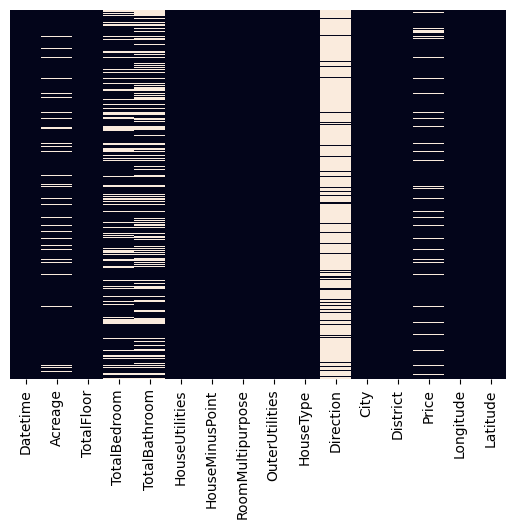

In [ ]:
_ = sns.heatmap(file.isnull(),yticklabels=False,cbar=False)

#### ***Drop unnessary columns.***

Heatmap trên cho thấy cột Direction có hơn 80% missing values nên
ta sẽ drop cột Direction.

In [ ]:
file.drop(columns = 'Direction', axis=1, inplace=True)

#### ***Filling missing values using MICE***

In [ ]:
file.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,9123.0,NaN,NaN,NaN,4814.671599,2775.781119,0.0,2418.5,4791.0,7243.5,9595.0
Datetime,9123.0,NaN,NaN,NaN,2022.581717,0.493304,2022.0,2022.0,2023.0,2023.0,2023.0
Acreage,8797.0,NaN,NaN,NaN,108.77849,1573.510665,8.0,44.0,60.0,85.0,105119.0
TotalFloor,9123.0,NaN,NaN,NaN,3.577222,3.174187,1.0,1.0,3.0,5.0,85.0
TotalBedroom,7331.0,NaN,NaN,NaN,3.762106,3.673903,1.0,2.0,3.0,4.0,111.0
TotalBathroom,6304.0,NaN,NaN,NaN,3.566148,3.90333,1.0,2.0,3.0,4.0,111.0
HouseUtilities,9123.0,NaN,NaN,NaN,2.999233,2.418616,0.0,1.0,2.0,4.0,23.0
HouseMinusPoint,9123.0,NaN,NaN,NaN,0.095035,0.354846,0.0,0.0,0.0,0.0,3.0
RoomMultipurpose,9123.0,NaN,NaN,NaN,0.918777,1.157931,0.0,0.0,1.0,2.0,10.0
OuterUtilities,9123.0,NaN,NaN,NaN,4.358983,2.874357,0.0,2.0,4.0,6.0,28.0


In [ ]:
file.shape

(9123, 16)

In [ ]:
file.isnull().sum()

index                  0
Datetime               0
Acreage              326
TotalFloor             0
TotalBedroom        1792
TotalBathroom       2819
HouseUtilities         0
HouseMinusPoint        0
RoomMultipurpose       0
OuterUtilities         0
HouseType              0
City                   0
District               0
Price                363
Longitude              0
Latitude               0
dtype: int64

**Quan sát dữ liệu trên, ta thấy:**
- Một số vùng ngoại ô, tỉnh lẻ; với diện tích đất khá nhỏ, dưới 200m2; nhưng có giá trên 50 tỷ đồng.
- Một số vùng thuộc các thành phố lớn, có diện tích phù hợp, nhưng có giá dưới 500 triệu đồng.
- Một số căn nhà có diện tích dưới 10m2.
- 'TotalFloor' > 30 (Với giá tiền <= 500 tỷ đồng, không thể nào tồn tại căn nhà có 85 tầng được).
- 'TotalBedroom' > 100 & 'Price' < 100 tỷ.


In [ ]:
print(file.shape)
cond1 = (file['Price'] >= 50) & (file['Acreage'] <= 200) & (~file['District'].isin(['Hoàn Kiếm', 'Ba Đình', 'Cầu Giấy', 'Tây Hồ', 'Quận 1']))
cond2 = (file['Price'] <= 0.5) & (file['City'].isin(['TP Hồ Chí Minh', 'Đà Nẵng', 'Hà Nội','Cần Thơ','Đồng Nai','Bà Rịa Vũng Tàu']))
cond3 = file['Acreage'] <= 10
cond4 = file['TotalFloor'] > 30
cond5 = (file['TotalBedroom'] > 100) & (file['Price'] < 100)
# Loại bỏ các hàng không hợp lệ
file=file[~cond1 & ~cond2 & ~cond3 & ~cond4 &~cond5]
print(file.shape)

(9596, 15)
(9473, 15)


In [ ]:
x=file.select_dtypes(include=[float, int]).columns
df_missing=file[x].copy()

##### **MICE forest**

MICE forest (Multiple Imputations by Chained Equations forest) là một phương pháp imputation based on random forests cho phép impute dữ liệu hiệu quả trong trường hợp các biến số có tương tác phức tạp. Một Dự án MICE forest bao gồm các bước sau:

Bước 1: Tiền xử lý dữ liệu và chọn biến:
- Xử lý dữ liệu bị khuyết: Thay thế các giá trị bị khuyết bằng giá trị ban đầu hoặc trung bình của biến đó (nếu có).
- Chuẩn hóa dữ liệu (nếu cần): Chuẩn hóa dữ liệu để đảm bảo các biến đều ở trong khoảng giá trị tương đương để giảm thiểu ảnh hưởng của các phương sai không đồng nhất.
- Chọn biến: Lựa chọn số lượng biến cần impute dựa trên số lượng giữ liệu bị thiếu tương ứng với mỗi biến.

Bước 2: Xây dựng model:
- Các model Rạng buộc ngẫu nhiên được xây dựng cho từng biến cần được impute dựa trên dữ liệu không bị khuyết. Các model này sẽ học cách dự đoán biến cần được impute dựa trên các biến còn lại.
- Sử dụng các model được xây dựng để dự đoán các giá trị bị khuyết của các biến cần được impute.
- Sử dụng các giá trị đã được dự đoán để tạo ra nhiều bản sao của dữ liệu bị khuyết.

Bước 3: Tính toán giá trị imputation cho mỗi biến khuyết:
- Mỗi bản sao được thực hiện imputations cho biến cần được impute đối với các giá trị bị khuyết.
- Tính tổng của tất cả các imputations để có được giá trị cuối cùng cho giá trị bị khuyết của biến đó.
- Lưu lại giá trị imputation cho từng bản sao.

Bước 4: Kết hợp các bản sao dữ liệu:
- Sau khi hoàn thành bước 3 cho tất cả các biến cần được impute, ta chọn giá trị impute cuối cùng bằng cách sử dụng trọng số đối với các từng bản sao dữ liệu để tạo thành một bộ dữ liệu hoàn chỉnh với đầy đủ các giá trị bị khuyết
- Phương pháp này sử dụng các model Rạng buộc ngẫu nhiên cho các giá trị thiếu để giải quyết các tương tác phức tạp, đồng thời cải thiện tốc độ và hiệu quả của quá trình imputation.





In [ ]:
!pip install miceforest --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 211.9 MB/s eta 0:00:00


In [ ]:
import miceforest as mf
# Create kernel.
kds = mf.ImputationKernel(
  df_missing,
  save_all_iterations=True,
  random_state=42
)

# Run the MICE algorithm for 500 iterations
kds.mice(iterations=500)

# Return the completed dataset.
df_imputed = kds.complete_data()

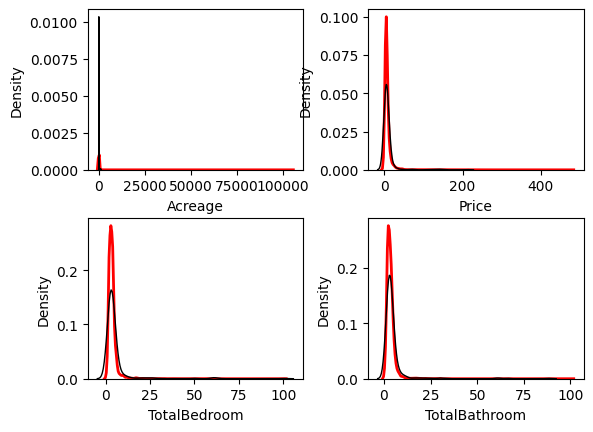

In [ ]:
kds.plot_imputed_distributions(wspace=0.3,hspace=0.3) #500

- Đường màu đen: phân phối của dữ liệu trước khi dùng MICE
- Đường màu đỏ: phân phối của dữ liệu sau khi dùng MICE

In [ ]:
df_imputed

,index,Datetime,Acreage,TotalFloor,TotalBedroom,TotalBathroom,HouseUtilities,HouseMinusPoint,RoomMultipurpose,OuterUtilities,Price,Longitude,Latitude
0,0,2023,130.0,1,7.0,6.0,4,0,4,4,9.20,106.664209,10.861411
1,1,2023,65.0,1,2.0,2.0,2,0,1,10,2.90,108.262775,16.004020
2,2,2023,90.0,10,5.0,4.0,5,0,4,10,14.00,105.855225,21.012198
3,4,2023,30.0,2,2.0,2.0,3,0,0,4,3.70,106.640304,10.844057
4,5,2023,38.0,9,3.0,3.0,5,0,0,9,4.40,106.698770,10.819914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9117,9590,2022,62.0,4,5.0,3.0,1,0,1,6,5.38,105.857447,20.975535
9119,9592,2022,208.0,1,3.0,2.0,1,0,0,2,10.80,106.771551,10.831135
9120,9593,2022,54.0,3,3.0,3.0,3,0,1,6,5.50,106.698770,10.819914
9121,9594,2022,110.0,1,2.0,1.0,5,0,0,15,5.50,108.800932,11.710747


In [ ]:
file[x] = df_imputed

In [ ]:
# standard deviation iteration = 1000
print('Standard deviation df_missing vs df_imputed:')
print('Price: ', np.std(df_missing['Price'])-np.std(df_imputed['Price']))
print('Acreage: ', np.std(df_missing['Acreage'])-np.std(df_imputed['Acreage']))
print('TotalBedroom: ',np.std(df_missing['TotalBedroom'])-np.std(df_imputed['TotalBedroom']))
print('TotalBathroom: ',np.std(df_missing['TotalBathroom'])-np.std(df_imputed['TotalBathroom']))
print('')

Standard deviation df_missing vs df_imputed:
Price:  -0.19649165117106548
Acreage:  28.76115616095467
TotalBedroom:  -1.5176988436857752
TotalBathroom:  -1.5091384830724022



In [ ]:
file.isnull().sum()

index               0
Datetime            0
Acreage             0
TotalFloor          0
TotalBedroom        0
TotalBathroom       0
HouseUtilities      0
HouseMinusPoint     0
RoomMultipurpose    0
OuterUtilities      0
HouseType           0
City                0
District            0
Price               0
Longitude           0
Latitude            0
dtype: int64

#### ***Find out outliers and drop***

In [ ]:
Q1, mean, Q3 = file['Price'].quantile([0.25,0.50,0.75])
IQR = Q3 - Q1
High = Q3+1.5*IQR
Low = Q1-1.5*IQR
Q1, mean, Q3, IQR, High, Low

(3.6, 5.3, 7.935, 4.334999999999999, 14.437499999999998, -2.9024999999999985)

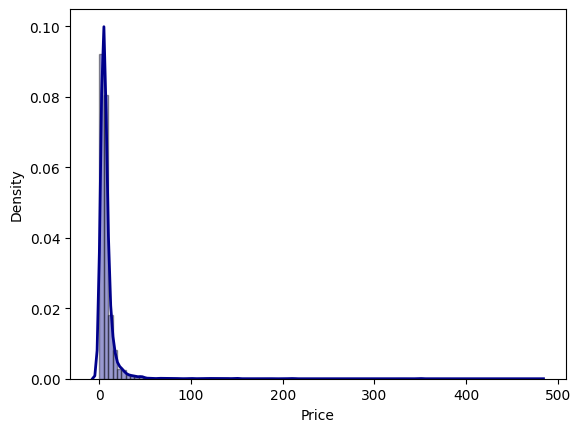

In [ ]:
sns.distplot(file['Price'],
             hist = True,
             bins=int(100),
             kde = True,
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth':2})
plt.show()

In [ ]:
Q1, mean, Q3 = file['Acreage'].quantile([0.25,0.50,0.75])
IQR = Q3 - Q1
High = Q3+1.5*IQR
Low = Q1-1.5*IQR
Q1, mean, Q3, IQR, High, Low

(44.0, 60.0, 85.0, 41.0, 146.5, -17.5)

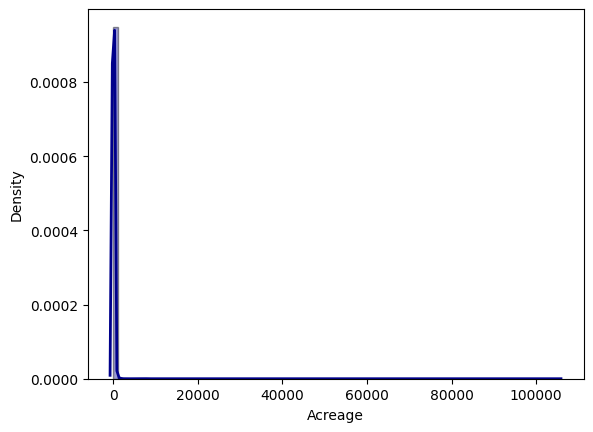

In [ ]:
sns.distplot(file['Acreage'],
             hist = True,
             bins=int(100),
             kde = True,
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth':2})
plt.show()

In [ ]:
file[file['Price']>300]

,index,Datetime,Acreage,TotalFloor,TotalBedroom,TotalBathroom,HouseUtilities,HouseMinusPoint,RoomMultipurpose,OuterUtilities,HouseType,City,District,Price,Longitude,Latitude
1152,1243,2023,1209.0,1,61.0,61.0,1,0,0,0,Bán Nhà mặt phố,Hà Nội,Long Biên,390.0,105.892153,21.025707
2031,2152,2023,550.0,22,38.0,61.0,6,0,0,5,Bán Nhà mặt phố,Hà Nội,Cầu Giấy,350.0,105.803438,21.029165
2305,2443,2023,550.0,22,61.0,88.0,6,0,0,5,Bán Nhà mặt phố,Hà Nội,Cầu Giấy,350.0,105.803438,21.029165
4087,4304,2023,1470.0,22,65.0,66.0,2,0,0,4,Bán Nhà mặt phố,Hà Nội,Hoàn Kiếm,350.0,105.845588,21.027059
4106,4323,2023,950.0,6,12.0,5.0,2,0,0,4,Bán Luxury home,TP Hồ Chí Minh,Quận 1,477.0,106.699573,10.775260
7460,7907,2022,622.0,9,50.0,88.0,6,0,1,8,Bán Nhà mặt phố,Hà Nội,Cầu Giấy,328.0,105.803438,21.029165


In [ ]:
file[file['Acreage']>5000]

,Datetime,Acreage,TotalFloor,TotalBedroom,TotalBathroom,HouseUtilities,HouseMinusPoint,RoomMultipurpose,OuterUtilities,HouseType,City,District,Price,Longitude,Latitude
1876,2023,7255.0,4,61.0,100.0,1,0,0,1,Bán Nhà mặt phố,TP Hồ Chí Minh,Quận 7,126.00,106.729713,10.737755
1922,2023,7255.0,6,5.0,6.0,3,0,0,5,Bán Nhà riêng,Hà Nội,Long Biên,12.00,105.892153,21.025707
2112,2023,18264.0,2,3.0,3.0,2,0,0,3,Bán Nhà mặt phố,Tiền Giang,Châu Thành,2.11,106.272274,10.421505
3056,2023,10400.0,1,33.0,88.0,4,0,0,3,Bán Nhà riêng,Đồng Nai,Định Quán,14.50,107.313877,11.209968
4575,2023,7770.0,6,4.0,3.0,0,0,1,6,Bán Nhà riêng,TP Hồ Chí Minh,Bình Tân,7.86,106.652276,10.803066
5284,2023,10196.0,1,3.0,2.0,0,0,1,1,Bán Nhà,Đắk Lắk,Krông Pắc,1.00,108.309304,12.709765
6469,2022,7770.0,2,38.0,100.0,3,0,0,6,Bán Nhà mặt phố,Tiền Giang,Châu Thành,150.00,106.272274,10.421505
6803,2022,100103.0,1,26.0,30.0,3,0,1,1,Bán Nhà,Bà Rịa Vũng Tàu,Xuyên Mộc,100.00,107.422576,10.610034
8118,2022,105119.0,1,28.0,30.0,6,0,1,1,Bán Nhà riêng,Thừa Thiên Huế,Huế,115.00,107.586339,16.463932


Drop những hàng có
Outliers
- 'Price' <= 0.5
- 'Acreage' <= 10 or 'Acreage' >= 7000
- 'TotalBedroom' <=0
- 'TotalBathroom' <=0

In [ ]:
#Xoá các hàng thỏa điều kiện
mask = ((file['Price'] <= 0.5)
       | (file['Acreage'] <= 10) | (file['Acreage'] >= 7000)
       | (file['TotalBedroom'] <= 0) | (file['TotalBathroom'] <= 0))
file1 = file.drop(index=file[mask].index)

In [ ]:
file1.shape

(8980, 16)

In [ ]:
file1 = file1.drop(columns = 'index')

In [ ]:
file1.to_csv('Data_for_model.csv', encoding = 'utf-8', index = False)

### **3. Visualie Heatmap using Kernel Density Estimation**

Kernel Density Estimation là một công cụ thống kê, thường được viết tắt là KDE, đây là một kỹ thuật để ước tính hàm mật độ xác suất, cho phép người dùng có cái nhìn tốt hơn về hàm mật độ xác suất của tập dữ liệu đang nghiên cứu so với khi sử dụng biểu dồ histogram truyền thống.

Các bước thực hiện:
1. Thu thập dữ liệu:

  Để có thể trực quan hoá Heatmap, trước hết cần chuyển đổi địa chỉ ngôi nhà về dạng toạ độ địa lý (kinh độ, vĩ độ).

2. Xác định độ rộng của kernel (h):

  Độ rộng của kernel quyết định độ chính xác của Kernel Density Estimation. Nếu h quá lớn, các kernel sẽ chồng lên nhau và kết quả sẽ thiếu chính xác. Nếu quá nhỏ, phân bố dữ liệu sẽ không được xác định rõ ràng. Đồng thời, giá trị h cũng phụ thuộc vào sự phân bố của dữ liệu.

3. Chọn hàm kernel:

  Kernel là một hàm đã chuẩn hóa có trung tâm tại điểm đang xét. Gaussian kernel là lựa chọn phổ biến để sử dụng trong Kernel Density Estimation.

  $K(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{x^2}{2\sigma^2}}$

>- x là khoảng cách tính từ điểm đang xét.
- sigma là độ lệch chuẩn của phân phối xác suất.
- sigma is the standard deviation of the probability distribution
- pi là hằng số pi, xấp xỉ bằng 3.14

4. Tính toán Kernel Density Estimation:

  Để tính toán Kernel Density Estimation, ta cần tính toán giá trị kernel với mỗi điểm trong tập dữ liệu, sau đó tính tổng giá trị kernel của tất cả các điểm dữ liệu đó.

  $f(x) = \frac{1}{n} \displaystyle \sum_{i = 1}^{n}K\bigg(\frac{x - X_i}{h}\bigg)$

5. Trực quan hóa kết quả:

  Mật độ Kernel được tính toán dựa trên số lượng điểm tập trung trong một khu vực, số lượng điểm trong nhóm càng lớn thì giá trị mật độ càng lớn. Bản đồ nhiệt Heatmap giúp đưa ra cái nhìn trực quan, dễ dàng xác định các điểm nóng và phân cụm của các điểm dữ liệu.

Kỹ thuật này có thể rất hữu ích nếu ta chỉ muốn trực quan hóa “hình dạng” của dữ liệu, như một kiểu thay thế liên tục cho một tập dữ liệu rời rạc. Kernel Density Estimation cũng có thể được sử dụng để tạo ra các điểm mà trông chúng như đến từ một tập dữ liệu nhất định - việc này có thể hỗ trợ cho các mô phỏng đơn giản mà trong đó các giá trị mô phỏng được mô hình hóa từ dữ liệu thực.

> Visualize Heatmap using Geopandas and Geoplot



Sử dụng dữ liệu từ file geojson để vẽ bản đồ Việt Nam

In [ ]:
vn_path = 'https://raw.githubusercontent.com/Vizzuality/growasia_calculator/master/public/vietnam.geojson'
vietnam = gpd.read_file(vn_path)
vietnam.head()

,cartodb_id,id_1,name,slug,geometry
0,17,33,Kiên Giang,vietnam-kiengiang,"MULTIPOLYGON (((105.40141 10.04024, 105.53898 ..."
1,62,49,Quảng Ninh,vietnam-quangninh,"MULTIPOLYGON (((106.53680 21.05216, 106.43977 ..."
2,47,11,Bình Phước,vietnam-binhphuoc,"MULTIPOLYGON (((106.75164 11.46867, 106.70483 ..."
3,44,12,Bình Thuận,vietnam-binhthuan,"MULTIPOLYGON (((107.50771 11.01104, 107.39390 ..."
4,26,18,Cà Mau,vietnam-camau,"MULTIPOLYGON (((105.26105 9.17828, 105.28011 9..."


In [ ]:
vietnam.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
data = pd.read_csv('Data_for_model.csv')
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
data_gdf.head()

,Datetime,Acreage,TotalFloor,TotalBedroom,TotalBathroom,HouseUtilities,HouseMinusPoint,RoomMultipurpose,OuterUtilities,HouseType,City,District,Price,Longitude,Latitude,geometry
0,2023,130.0,1,7.0,6.0,4,0,4,4,Bán Nhà riêng,TP Hồ Chí Minh,Quận 12,9.2,106.664209,10.861411,POINT (106.66421 10.86141)
1,2023,65.0,1,2.0,2.0,2,0,1,10,Bán Nhà riêng,Đà Nẵng,Ngũ Hành Sơn,2.9,108.262775,16.004020,POINT (108.26277 16.00402)
2,2023,90.0,10,5.0,4.0,5,0,4,10,Bán Nhà riêng,Hà Nội,Hai Bà Trưng,14.0,105.855225,21.012198,POINT (105.85522 21.01220)
3,2023,30.0,2,2.0,2.0,3,0,0,4,Bán Nhà riêng,TP Hồ Chí Minh,Gò Vấp,3.7,106.640304,10.844057,POINT (106.64030 10.84406)
4,2023,38.0,9,3.0,3.0,5,0,0,9,Bán Nhà riêng,TP Hồ Chí Minh,Bình Thạnh,4.4,106.698770,10.819914,POINT (106.69877 10.81991)


In [ ]:
# explode MultiPolygons into individual Polygons
vietnam = vietnam.buffer(0.000001).explode()

# world map
ax = gplt.polyplot(vietnam, projection=gcrs.AlbersEqualArea(), edgecolor='darkgrey', facecolor='#DDEEFF', linewidth=.3, figsize=(12, 8), zorder=1)

# kernel density estimate plot
gplt.kdeplot(df=data_gdf, cmap='Reds', shade=True, alpha=0.8, clip=vietnam, figsize=(16, 8), ax=ax)

# geospatial scatter plot
gplt.pointplot(df=data_gdf, s=1, color='lightblue', ax=ax)

plt.title('Heatmap using Kernel Density Estimation');

> Visualize Heatmap using Basemap



In [ ]:
!pip install basemap "basemap-data-hires == 1.3.0b1"
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde

In [ ]:
dt = data.drop(columns=['Acreage','TotalFloor','TotalBedroom','TotalBathroom','HouseUtilities'
                     ,'HouseMinusPoint','RoomMultipurpose','OuterUtilities','HouseType','City','District'])

In [ ]:
# Get matrices/arrays of houses IDs and locations
latlon = np.vstack([dt['Longitude'].values,dt['Latitude'].values]).T
times = np.array([d == 2023 for d in dt['Datetime']], dtype='int')

In [ ]:
grid_size = 0.01
x_left_lower_corner = 101
Nx = 950
y_left_lower_corner = 8
Ny = 1550

In [ ]:
xmin = x_left_lower_corner + grid_size
xmax = xmin + (Nx * grid_size)

ymin = y_left_lower_corner + grid_size
ymax = ymin + (Ny * grid_size)

xgrid = np.arange(xmin, xmax, grid_size)
ygrid = np.arange(ymin, ymax, grid_size)

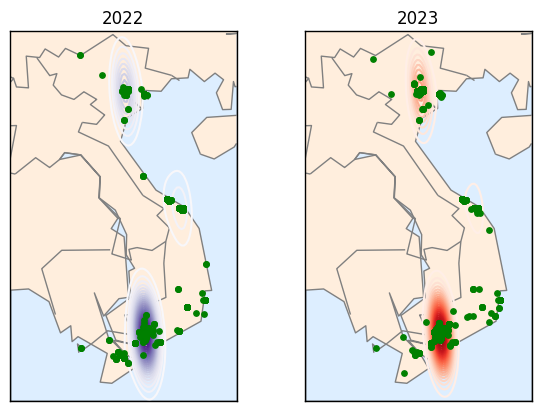

In [ ]:
# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
year = [2022, 2023]
cmaps = ['Purples', 'Reds']

# Create a grid of points to evaluate the KDE
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

for i, axi in enumerate(ax):
    axi.set_title(year[i])

    # plot coastlines with basemap
    m = Basemap(projection='cyl', resolution='c', llcrnrlat=ymin, urcrnrlat=ymax, llcrnrlon=xmin, urcrnrlon=xmax, ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.fillcontinents(color='#FFEEDD')
    m.drawcoastlines(color='gray', zorder=2, linewidth=1)
    m.drawcountries(color='gray', zorder=2, linewidth=1)

    # Calculate the kernel density estimate of the points
    kde = gaussian_kde(latlon[times == i].T)

    # Evaluate the KDE at the grid points
    xy = np.vstack([latlon[times == i][:, 0], latlon[times == i][:, 1]])
    z = gaussian_kde(xy)(xy)
    density = kde(positions).reshape(xx.shape)

    # plot point density
    m.scatter(latlon[times == i][:, 0], latlon[times == i][:, 1], s=15, latlon=True, zorder=3, color='green')

    # plot contours of the density
    levels = np.linspace(0, z.max(), 25)
    m.contour(xx, yy, density, levels=levels, cmap=cmaps[i])

## **Feature Engineering**

### **1. Encoding categorical variables**

> **Encoding categorical variables**

*Mã hóa dữ liệu phân loại* là một quá trình chuyển đổi dữ liệu thành định dạng số nguyên.

**[Để](https:// [văn bản liên kết](https://))** có thể sử dụng các categorical variables trong mô hình máy học, các biến phân loại này này cần được mã hoá thành các giá trị số mà mô hình có thể tiếp nhận và xử lý.

Binary Encoder là một kỹ thuật dùng để mã hoá các biến phân loại này.
1. Đầu tiên các biến phân loại (categorical feature) sẽ được đưa về dạng số bằng cách sử dụng Ordinal Encoder, có nghĩa là mỗi giá trị phân loại sẽ được gán với một giá trị nguyên tương ứng.
2. Sau đó, các giá trị số này sẽ được chuyển đổi sang dạng mã nhị phân, ví dụ, 3 tương ứng với 011, 4 tương ứng với 100.
3. Log(n) cột mới sẽ được tạo ra tương ứng với số chữ số của các giá trị nhị phân, với n là số giá trị của biến phân loại. Các mã nhị phân sẽ được ánh xạ lên các cột này sử dụng 0 và 1, tương tự như cách biểu diễn số nhị phân.

Khi biến phân loại có một lượng lớn giá trị unique, Binary Encoder là phương pháp mã hoá tốt và tiết kiệm bộ nhớ hơn, do nó tạo ra ít thuộc tính mới hơn (log(n) new features) so với kỹ thuật khác như One-hot Encoder (n new features).

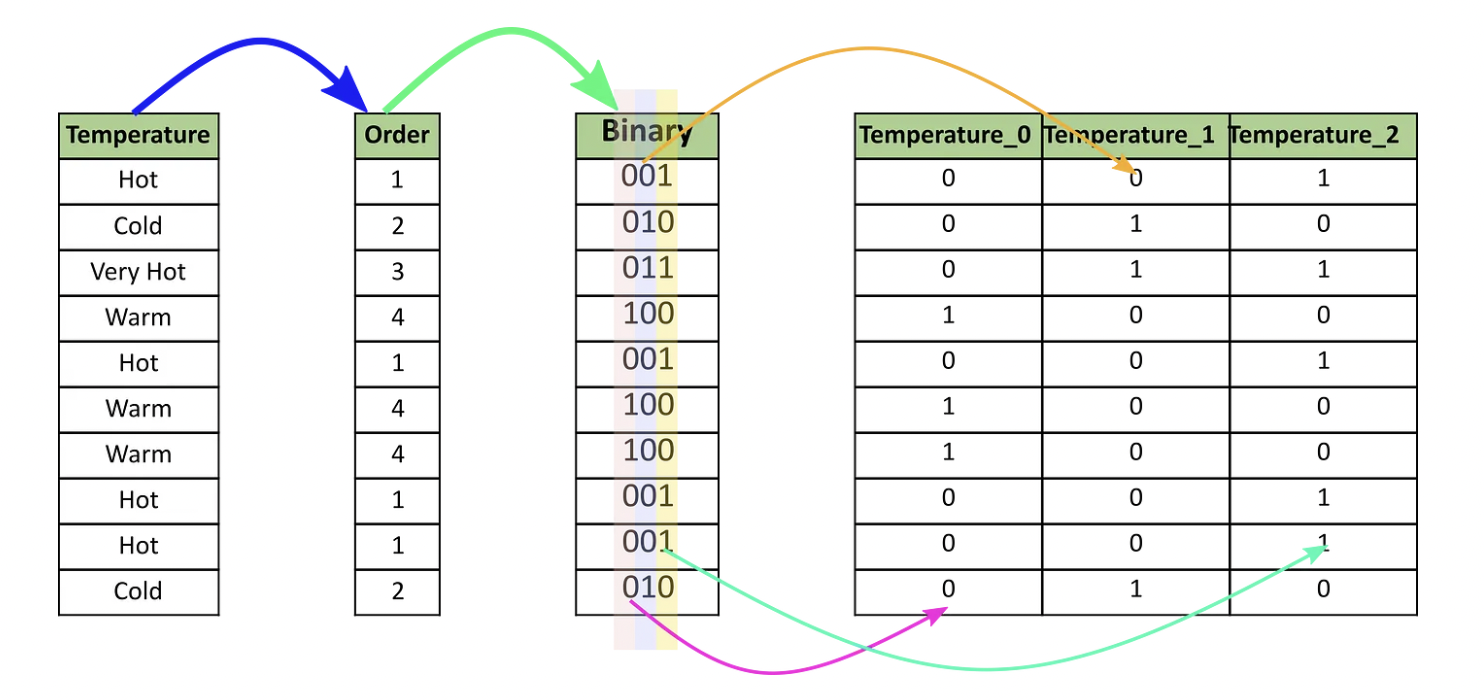


In [ ]:
geography = pd.read_csv('Data_for_model.csv')
geography = geography.drop(columns = ['City', 'District'])

In [ ]:
encoder = ce.BinaryEncoder(cols=['HouseType','Datetime'],return_df=True)
data_encoded = encoder.fit_transform(geography)
data_encoded.head()

,Datetime_0,Datetime_1,Acreage,TotalFloor,TotalBedroom,TotalBathroom,HouseUtilities,HouseMinusPoint,RoomMultipurpose,OuterUtilities,HouseType_0,HouseType_1,HouseType_2,Price,Longitude,Latitude
0,0,1,130.0,1,7.0,6.0,4,0,4,4,0,0,1,9.2,106.664209,10.861411
1,0,1,65.0,1,2.0,2.0,2,0,1,10,0,0,1,2.9,108.262775,16.004020
2,0,1,90.0,10,5.0,4.0,5,0,4,10,0,0,1,14.0,105.855225,21.012198
3,0,1,30.0,2,2.0,2.0,3,0,0,4,0,0,1,3.7,106.640304,10.844057
4,0,1,38.0,9,3.0,3.0,5,0,0,9,0,0,1,4.4,106.698770,10.819914


### **2. Findout important features for the model**

***Price*** là *target values*

In [ ]:
X=data_encoded.drop(['Price'],axis=1)
y=data_encoded[['Price']].values.reshape(-1,1)

In [ ]:
X.shape, y.shape

((8980, 15), (8980, 1))

Extra Trees Regression là một thuật toán machine learning thuộc họ thuật toán Decision Tree. Nó là một phương pháp ensemble learning dựa trên Decision Tree. Trong Extra Trees Regression, nhiều Decision Tree được xây dựng bằng cách sử dụng phân tách ngẫu nhiên dữ liệu huấn luyện. Những cây này được phát triển cho đến khi đạt được số lượng nút tối đa hoặc số lượng mẫu tối thiểu cần thiết để tách một nút.

Đầu tiên, một tập hợp các cây quyết định được xây dựng bằng cách chọn ngẫu nhiên các tập hợp con từ dữ liệu huấn luyện và chọn các tính năng ngẫu nhiên để phân tách. Đối với mỗi cây, các bước sau đây được thực hiện:
- Decision Tree được tạo bằng cách chia dữ liệu thành hai tập hợp con khác nhau với điểm phân tách được chọn ngẫu nhiên.

- Dự đoán sau đó được thực hiện bằng cách sử dụng các giá trị nút lá trên dữ liệu đầu vào mới, trong đó đạt được nút lá bằng cách thực hiện theo các phần tách được xác định trong Decision Tree.

- Khi một tập hợp các cây đã được tạo, dự đoán cuối cùng được thực hiện bằng cách lấy trung bình các dự đoán riêng lẻ của tất cả các cây được tạo.


Các bước trên có thể được biểu diễn dưới dạng toán học như sau:

Đặt $X$ là các tính năng đầu vào và $Y$ là biến đầu ra.

Tạo tập cây quyết định $T$ = {$T_1$, $T_2$, ..., $T_n$}

Với mỗi cây $T_i \in T$:
- Chọn ngẫu nhiên một tập con $S$ của dữ liệu huấn luyện
- Chọn ngẫu nhiên một tập hợp các tính năng $F_i$ để chia nhỏ
- Tạo cây quyết định Ti sử dụng tập con $S$ đã chọn và các tính năng $F_i$

Đối với đầu vào mới $x$, hãy lấy giá trị dự đoán bằng cách lấy trung bình các dự đoán của tất cả các Decision Tree trong tập $T$:

$\hat{y} = \frac{1}{n} . \displaystyle \sum_{i = 1}^{n} T_i(x) $

Trong các phương trình trên, $T_i(x)$ biểu thị đầu ra dự đoán của cây thứ $i$ cho đầu vào $x$ và $n$ biểu thị số lượng cây trong tập hợp $T$.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
model=ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [ ]:
print(model.feature_importances_)

[0.01035439 0.00969863 0.1812032  0.04411103 0.24048203 0.23337836
 0.03054228 0.01831397 0.03391663 0.03447153 0.02827854 0.02118204
 0.0324591  0.03278425 0.04882404]


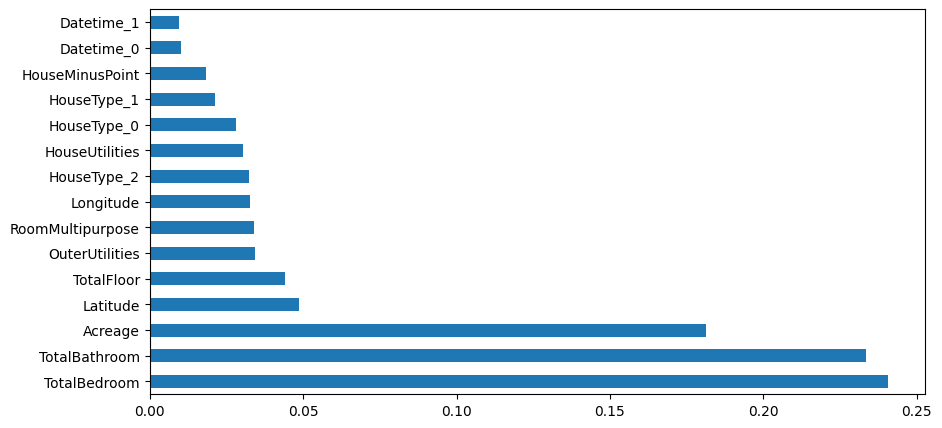

In [ ]:
plt.figure(figsize=(10,5))
feature_importance=pd.Series(model.feature_importances_,index=X.columns)
feature_importance.nlargest(30).plot(kind='barh')
plt.show()

Top 10 features for model:
1.   TotalBedroom
4.   TotalBathroom
2.   Acreage
3.   Latitude
5.   TotalFloor
6.   OuterUtilities
7.   RoomMultipurpose
8.   Longitude
9.   HouseType_2
10.  HouseUtilities

